## TDMS file importer and converter

This script takes a set of files generated by the Ski Boot Machine at Montebelluna and condenses them into a singele DataFrame (exported as csv).

TDMS files information are contained in groups. A Group is the content that would be imported to an excel "sheet". It can contain Min and Max data for a session, or time stamped strain and deformation data, and possibly other kind of information. For more on what is exported, please refer to machine documentation or the local specialist in Montebelluna.

This script focalizes on the time data. Hence, a loop is define to look at groups that contain the string "Saves_Session".

Here we use the .read() method that reads all the file at once. In case the file is too large, please refer to documentation on the npTDMS python package about the .open() method that allows reading only specific groups.

In [78]:
# For each tdms file below it is required to insert an experiment name to be used as a tag in the consolidated file
file_names = ["Fatica 2021-01-08_11-09-39", "Fatica 2021-01-08_11-27-44", "Fatica 2021-01-08_14-47-31", "Fatica 2021-01-08_12-22-59"]
experiment_names = ["DxAmbient", "SxAmbient", "DxCold", "SxCold"]

# String contained in the group name denoting a time series
str_to_search = "Saves_Session"

import pandas as pd
from nptdms import TdmsFile

# create dataframe to contain the consolidated data
df = pd.DataFrame()

for i, filename in enumerate(file_names):
    # import tdms file
    tdms_file = TdmsFile.read(filename + ".tdms")
    
    # iterate through the file's groups
    for group in tdms_file.groups():
        group_name = group.name
        #print("Group name: " + str(group_name))
        
        # identify groups with the time series related tag
        if str_to_search in group.name:
            # get dataframe with data contained in group
            df_session = getDataFromGroup(group)
            
            # create the session, cycle and experiment tags
            session = int(group.name.split("_")[1].split(" ")[1])
            cycle = int(group.name.split("_")[2].split("e")[1])
            df_session["session #"] = session
            df_session["cycle #"] = cycle
            df_session["experiment"] = experiment_names[i]
            
            # debug for each session
            print("Experiment: " + experiment_names[i] + " Session: " + str(session) + " Data points: " + str(df_session.shape[0]))
            #print(df_session.head())
            
            # append session data to main dataframe
            df = df.append(df_session)

df.reset_index(drop = True, inplace = True)
print(df.info())

Experiment: DxAmbient Session: 1 Data points: 2857
Experiment: DxAmbient Session: 1 Data points: 3
Experiment: DxAmbient Session: 2 Data points: 2857
Experiment: DxAmbient Session: 2 Data points: 3
Experiment: DxAmbient Session: 3 Data points: 2857
Experiment: DxAmbient Session: 3 Data points: 3
Experiment: DxAmbient Session: 4 Data points: 2857
Experiment: DxAmbient Session: 4 Data points: 3
Experiment: DxAmbient Session: 5 Data points: 2857
Experiment: DxAmbient Session: 5 Data points: 3
Experiment: SxAmbient Session: 1 Data points: 2857
Experiment: SxAmbient Session: 1 Data points: 2858
Experiment: SxAmbient Session: 1 Data points: 2857
Experiment: SxAmbient Session: 1 Data points: 2857
Experiment: SxAmbient Session: 1 Data points: 2857
Experiment: SxAmbient Session: 1 Data points: 2857
Experiment: SxAmbient Session: 1 Data points: 2857
Experiment: SxAmbient Session: 1 Data points: 2857
Experiment: SxAmbient Session: 1 Data points: 2858
Experiment: SxAmbient Session: 1 Data points: 

In [75]:
# Here we select the relevant fields to export from the ones available at the tdms file. 
chans_to_get = ["Data e ora", "Carico [N]", "Posizione motore [°]", "Temperatura [°C]"]

# Names as wished in the output file. Array needs one entry for each field listed above
chan_names = ["time", "force", "position", "temp"]

def getDataFromGroup(group):
    # create dataframe
    df_session = pd.DataFrame(columns = chan_names)
    
    for i, channel_name in enumerate(chans_to_get):
        channel = group[channel_name]
        df_session[chan_names[i]] = channel[:]
            
    # set index as time stamp
#     df_session.set_index("Time", inplace = True)
    
    return df_session

Finaly we can reoder the dataframe

In [79]:
import numpy as np

cols = np.array(df.columns.tolist())
# order of columns (refer to df_info to see and change order)
order = [0, 6, 4, 5, 2, 1, 3]

df = df[cols[order]]

print(df.columns)

Index(['time', 'experiment', 'session #', 'cycle #', 'position', 'force',
       'temp'],
      dtype='object')


## Summary statistics

Let's look at the experiments, times and volumes of information to check with reality.

In [100]:
import datetime

df_exp = pd.DataFrame()

df_exp["Start time"] = df.groupby("experiment")["time"].min().dt.strftime("%H:%M:%S")
df_exp["Length"] = df.groupby("experiment")["time"].max() - df.groupby("experiment")["time"].min()

print(df_exp)

           Start time                 Length
experiment                                  
DxAmbient    10:10:55 0 days 00:01:34.017500
DxCold       13:49:16 0 days 00:01:34.018499
SxAmbient    10:41:05 0 days 00:01:34.020501
SxCold       11:30:13 0 days 00:01:34.017501


Finally let's look at the lines

Experiment: DxAmbient


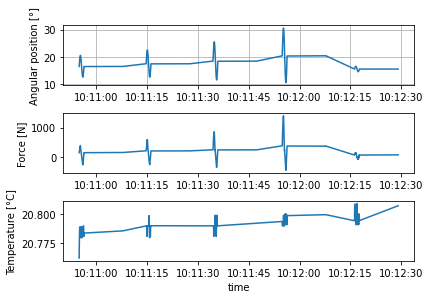

Experiment: SxAmbient


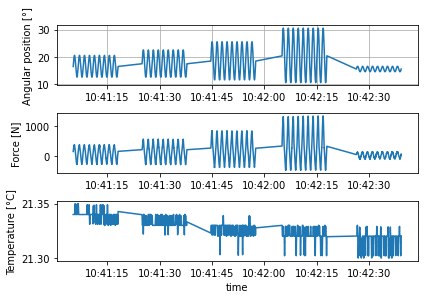

Experiment: DxCold


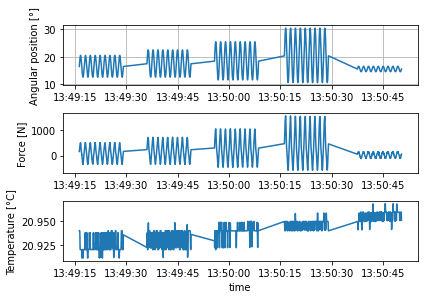

Experiment: SxCold


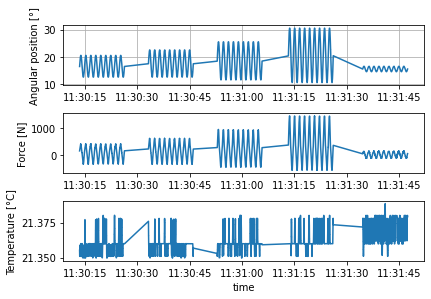

In [114]:
import matplotlib.pyplot as plt

for exp in experiment_names:
    
    df_exp = df[df["experiment"] == exp]
    
    t = df_exp["time"]
    p = df_exp["position"]
    f = df_exp["force"]
    temp = df_exp["temp"]

    print("Experiment: " + exp)
    fig, axs = plt.subplots(3, 1)
    axs[0].plot(t, p)
    axs[0].set_ylabel('Angular position [°]')
    axs[1].plot(t, f)
    axs[1].set_ylabel('Force [N]')
    axs[2].plot(t, temp)
    axs[2].set_ylabel('Temperature [°C]')
    axs[2].set_xlabel('time')
    axs[0].grid(True)
    fig.tight_layout()
    plt.show()

## CSV export

Now let's export the dataframe as a csv

In [115]:
df.to_csv("Montebelluna_8Jan21_time_series.csv")